<a href="https://colab.research.google.com/github/Anishmodi20/Sample-Set-LLC/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install openpyxl
!pip install fancyimpute
!pip install scikit-optimize

# **Exploratory Analysis**

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from fancyimpute import IterativeImputer
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore')

In [42]:
# Read Data Dictionary
description = pd.read_excel('/content/BA - Assignment Part 1 data set.xlsx', sheet_name='Data Dict', header=1, usecols=[1, 2, 3])

# Read the main dataset
data = pd.read_excel('/content/BA - Assignment Part 1 data set.xlsx', sheet_name='E Comm')

In [43]:
# Display first few rows
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [44]:
# Check the shape of the dataset
print(data.shape)

# Display basic information about the dataset
data.info()


(5630, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberO

In [45]:
# Display summary statistics for numerical columns
data.describe(include='all')

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630,5630.000000,5379.000000,5630,5630,5375.000000,5630.000000,5630,5630.000000,5630,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
unique,NaN,NaN,NaN,3,NaN,NaN,7,2,NaN,NaN,6,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Mobile Phone,NaN,NaN,Debit Card,Male,NaN,NaN,Laptop & Accessory,NaN,Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2765,NaN,NaN,2314,3384,NaN,NaN,2050,NaN,2986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,52815.500000,0.168384,10.189899,NaN,1.654707,15.639896,NaN,NaN,2.931535,3.688988,NaN,3.066785,NaN,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,1625.385339,0.374240,8.557241,NaN,0.915389,8.531475,NaN,NaN,0.721926,1.023999,NaN,1.380194,NaN,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,50001.000000,0.000000,0.000000,NaN,1.000000,5.000000,NaN,NaN,0.000000,1.000000,NaN,1.000000,NaN,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,NaN,1.000000,9.000000,NaN,NaN,2.000000,3.000000,NaN,2.000000,NaN,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,NaN,1.000000,14.000000,NaN,NaN,3.000000,4.000000,NaN,3.000000,NaN,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,54222.750000,0.000000,16.000000,NaN,3.000000,20.000000,NaN,NaN,3.000000,4.000000,NaN,4.000000,NaN,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500


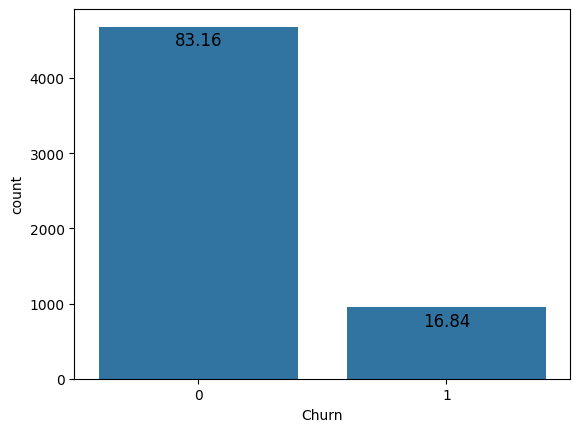

In [46]:
# Visualize Churn Distribution
ax = sns.countplot(x='Churn', data=data)
for a in ax.patches:
    ax.annotate(format((a.get_height()/data.shape[0])*100,'.2f'), (a.get_x() + a.get_width()/2., a.get_height()),\
                ha='center', va='center', size=12, xytext=(0, -10), textcoords='offset points')
plt.show()


**The ratio of retained customer to churned customer is about 5:1**

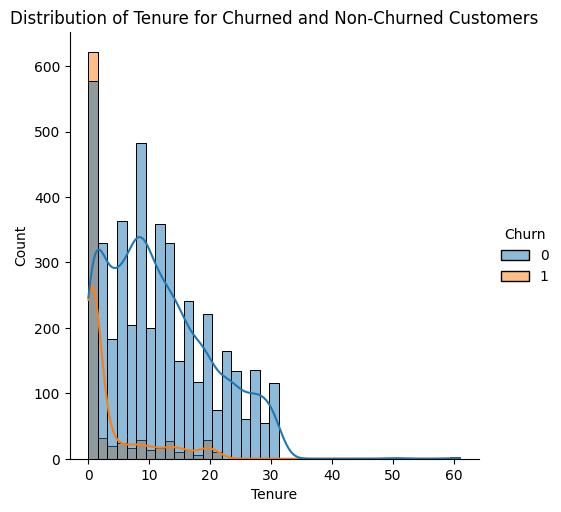

In [47]:
# Visualize Distribution of Tenure
sns.displot(x='Tenure', kde=True, hue='Churn', data=data)
plt.title("Distribution of Tenure for Churned and Non-Churned Customers")
plt.show()


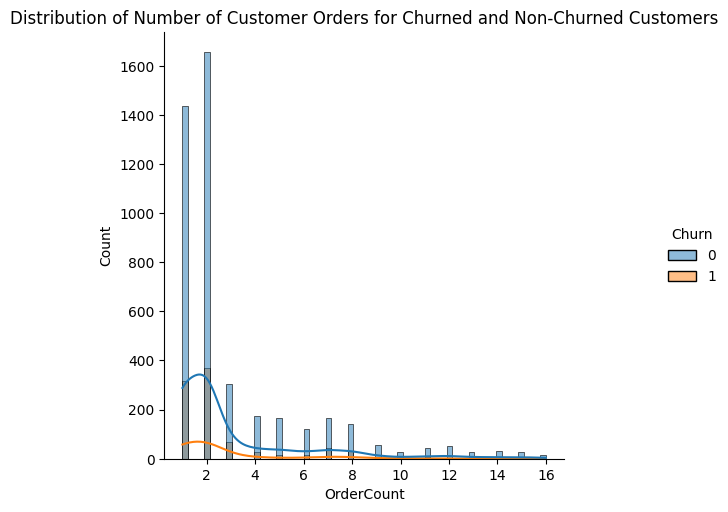

In [48]:
# Visualize Distribution of Number of Customer Orders
sns.displot(x='OrderCount', kde=True, hue='Churn', data=data)
plt.title("Distribution of Number of Customer Orders for Churned and Non-Churned Customers")
plt.show()

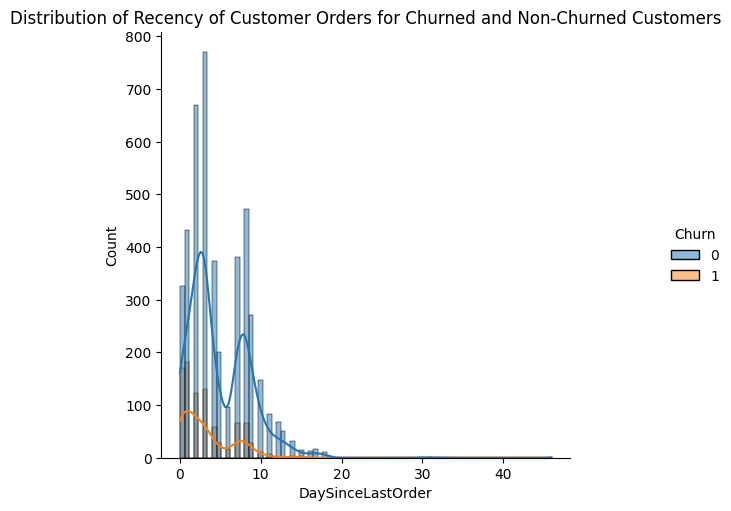

In [49]:
# Visualize Distribution of Recency of Customer Orders
sns.displot(x='DaySinceLastOrder', kde=True, hue='Churn', data=data)
plt.title("Distribution of Recency of Customer Orders for Churned and Non-Churned Customers")
plt.show()

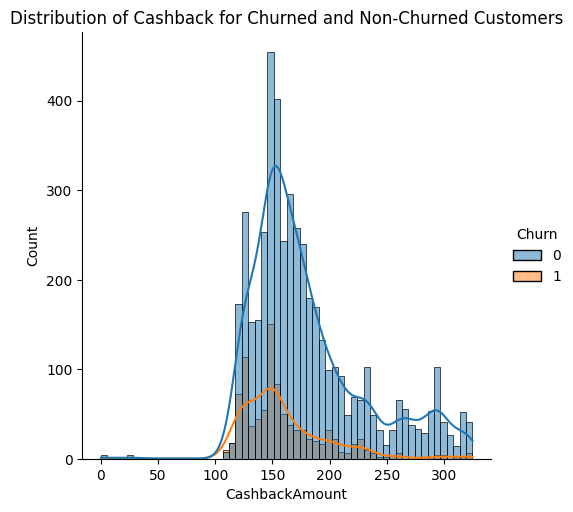

In [50]:
# Visualize Distribution of Cashback for Customers
sns.displot(x='CashbackAmount', kde=True, hue='Churn', data=data)
plt.title('Distribution of Cashback for Churned and Non-Churned Customers')
plt.show()

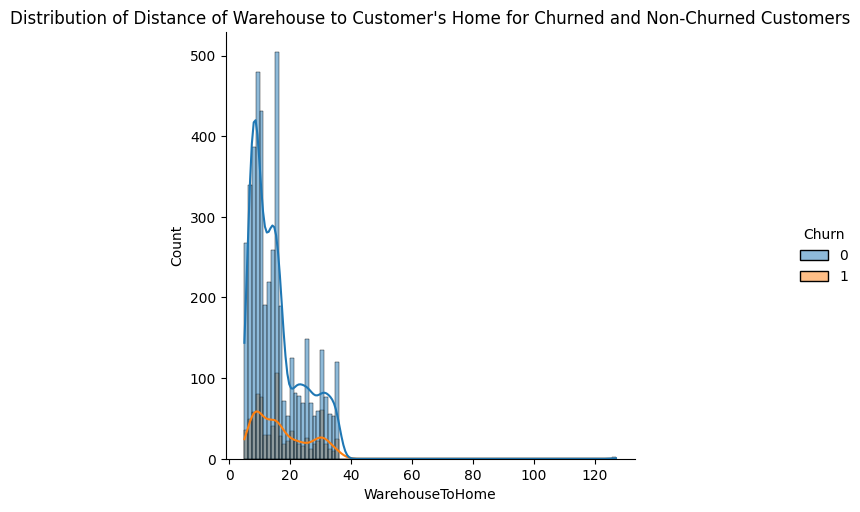

In [51]:
# Visualize Distribution of Distance of Warehouse to Customer's Home
sns.displot(x='WarehouseToHome', kde=True, hue='Churn', data=data)
plt.title("Distribution of Distance of Warehouse to Customer's Home for Churned and Non-Churned Customers")
plt.show()

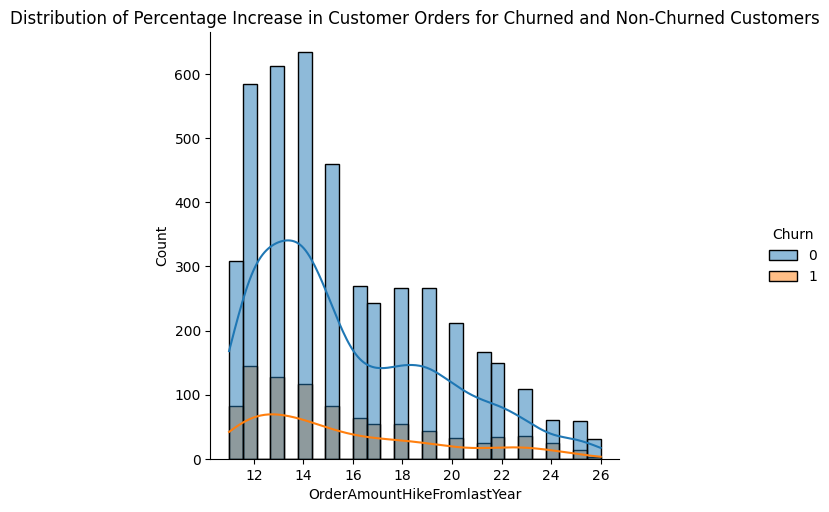

In [52]:
# Visualize Distribution of Percentage Increase in Customer Orders
sns.displot(x='OrderAmountHikeFromlastYear', kde=True, hue='Churn', data=data)
plt.title("Distribution of Percentage Increase in Customer Orders for Churned and Non-Churned Customers")
plt.show()

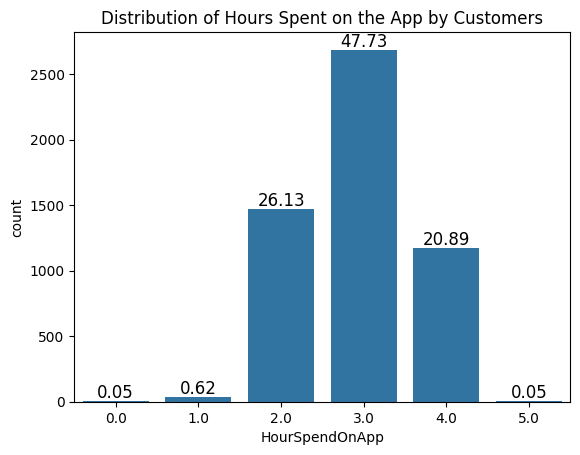

In [53]:
# Visualize Distribution of Hours Spent on the App
axx = sns.countplot(x='HourSpendOnApp', data=data)
for a in axx.patches:
    axx.annotate(format((a.get_height()/data.shape[0])*100,'.2f'), (a.get_x() + a.get_width()/2., a.get_height()),\
                ha='center', va='center', size=12, xytext=(0, 6), textcoords='offset points')
plt.title("Distribution of Hours Spent on the App by Customers")
plt.show()

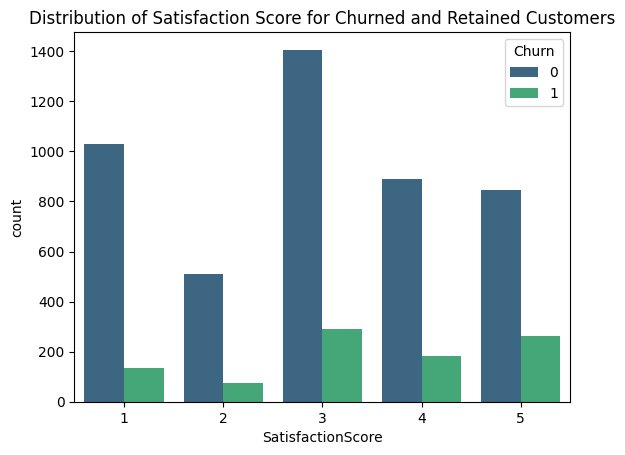

In [54]:
# Visualize Distribution of Satisfaction Score
sns.countplot(x='SatisfactionScore', hue='Churn', palette='viridis', data=data)
plt.title("Distribution of Satisfaction Score for Churned and Retained Customers")
plt.show()

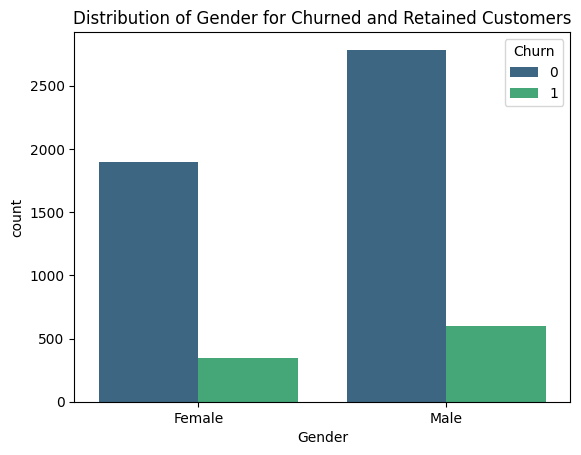

In [55]:
# Visualize Distribution of Gender
sns.countplot(x='Gender', hue='Churn', palette='viridis', data=data)
plt.title("Distribution of Gender for Churned and Retained Customers")
plt.show()

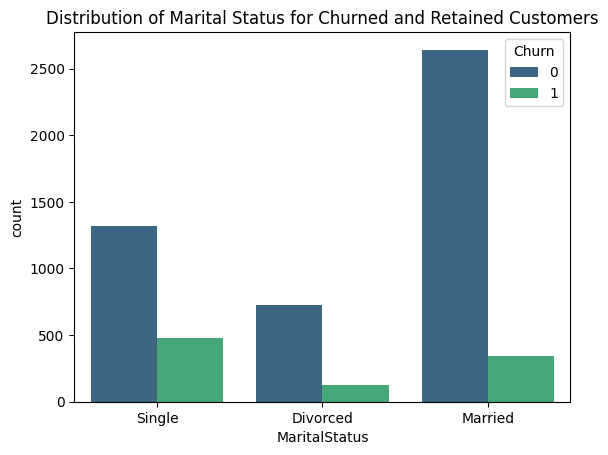

In [56]:
# Visualize Distribution of Marital Status
sns.countplot(x='MaritalStatus', hue='Churn', palette='viridis', data=data)
plt.title("Distribution of Marital Status for Churned and Retained Customers")
plt.show()

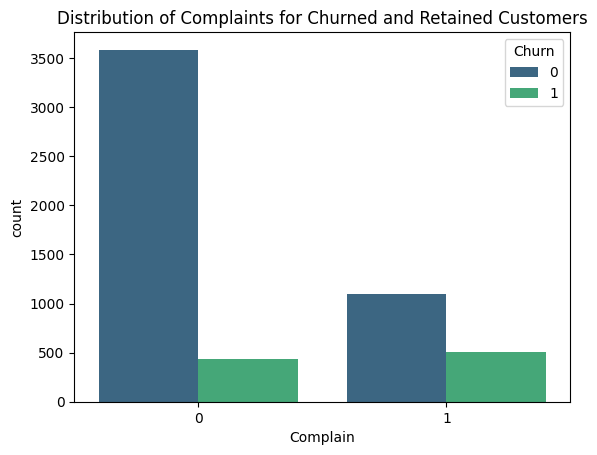

In [57]:
# Visualize Distribution of Complaints
sns.countplot(x='Complain', hue='Churn', palette='viridis', data=data)
plt.title("Distribution of Complaints for Churned and Retained Customers")
plt.show()

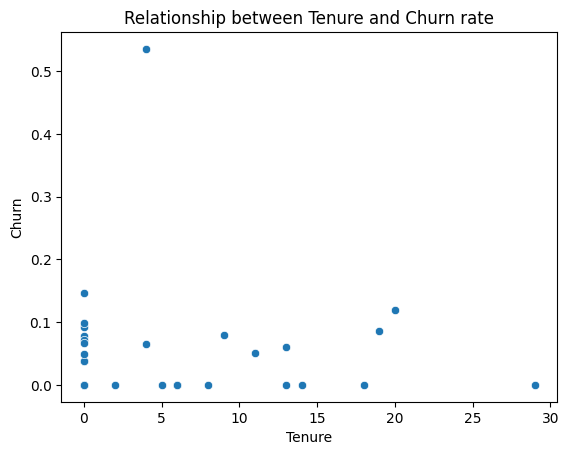

In [58]:
# Relationship between Tenure and Churn rate
sns.scatterplot(x=data['Tenure'], y=data.groupby('Tenure').Churn.mean())
plt.title("Relationship between Tenure and Churn rate")
plt.show()

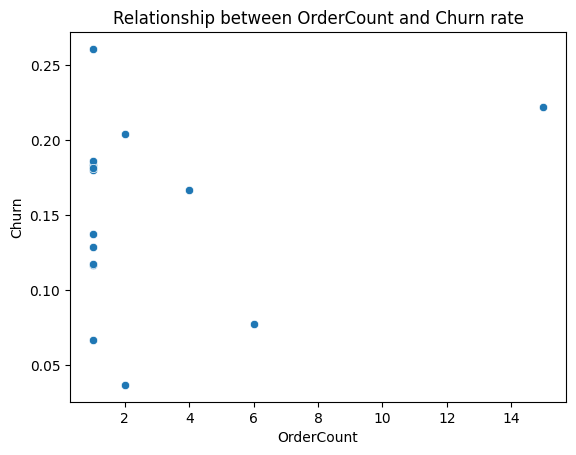

In [59]:
# Relationship between OrderCount and Churn rate
sns.scatterplot(x=data['OrderCount'], y=data.groupby('OrderCount').Churn.mean())
plt.title("Relationship between OrderCount and Churn rate")
plt.show()

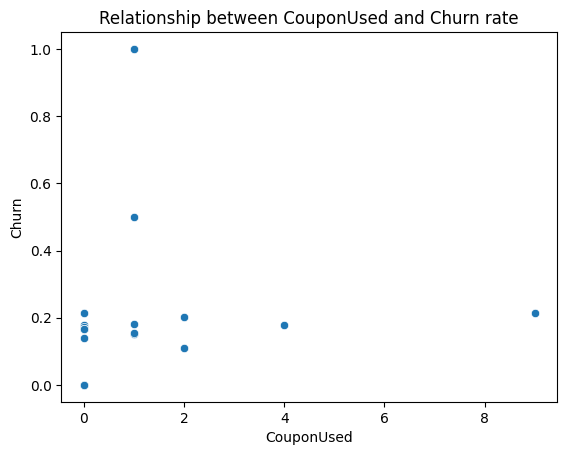

In [60]:
# Relationship between CouponUsed and Churn rate
sns.scatterplot(x=data['CouponUsed'], y=data.groupby('CouponUsed').Churn.mean())
plt.title("Relationship between CouponUsed and Churn rate")
plt.show()

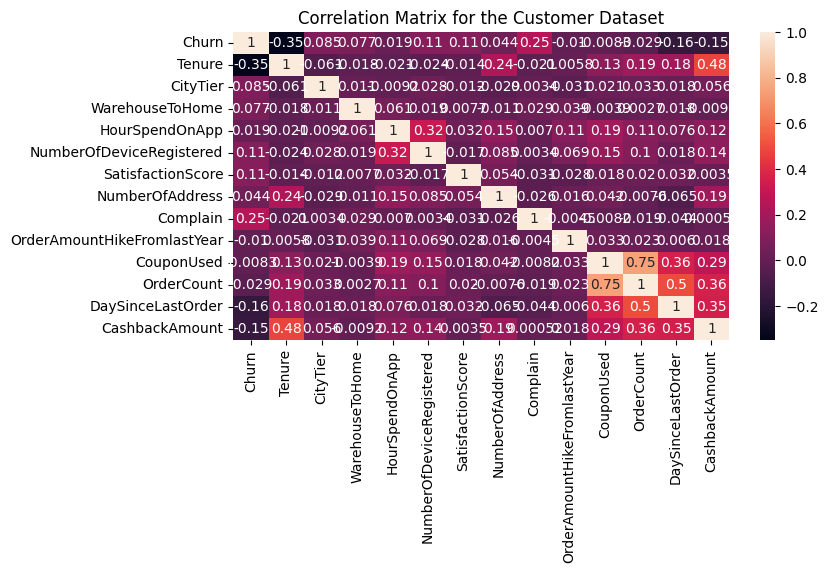

In [61]:
# Correlation Matrix
plt.figure(figsize=(8, 4))
sns.heatmap(data.drop('CustomerID', axis=1).corr(), annot=True)
plt.title("Correlation Matrix for the Customer Dataset")
plt.show()

# **Factors influencing churn:**
1. **Outliers:**

* Outliers in features like Tenure, Days
since last order, cashback amount, and warehouse to home don't significantly affect tree models; hence, they are retained.

2. **App Usage:**

* Most customers spend around 3 hours on the app, with 94.75% falling within 2 to 4 hours, guiding targeted engagement strategies.

3. **Marital Status Impact:**

* Singles show a higher churn rate, suggesting the need for focused retention efforts and tailored marketing.

4. **Complaints Influence:**

* Customers with complaints exhibit higher churn; addressing concerns proactively can improve satisfaction and retention.

5. **Tenure-Churn Relationship:**

* A discernible tenure-churn relationship, particularly around 4 to 5 tenure, indicates a critical period for targeted retention strategies.

# **Data Preprocessing**

   It includes three steps -
* Missing Value Treatment
* Class Imbalance Handling Using SMOTE
* KNN Imputation

## **Missing Value Treatment**

In [62]:
# Count the number of missing values across each column
missing_values = data.isnull().sum()

# Count the total number of missing values in the dataset
total_missing = missing_values.sum()

# Count the number of rows with missing values
rows_with_missing = data[data.isnull().any(axis=1)].shape[0]

print(f'The number of missing values: {total_missing}')
print(f'The number of rows with missing values: {rows_with_missing}')

The number of missing values: 1856
The number of rows with missing values: 1856


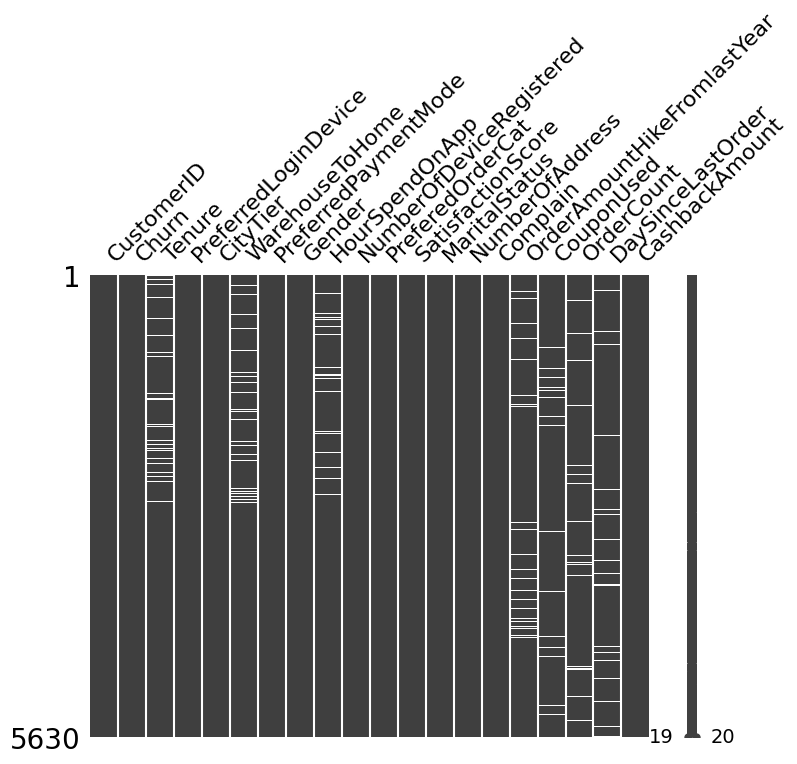

In [63]:
# Description of data
data_description = data.describe()

# Plot the missingness matrix
msno.matrix(data, figsize=(8, 6))
plt.show()

**The missing values dont follow any pattern, so I will sort the data and see if I can find a pattern.**

<Figure size 800x600 with 0 Axes>

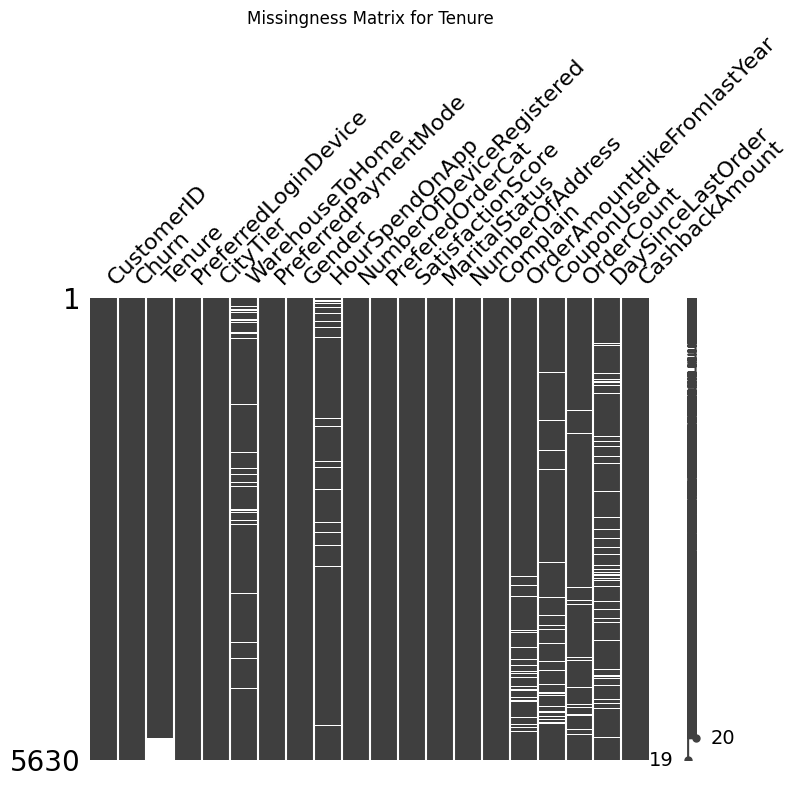

<Figure size 800x600 with 0 Axes>

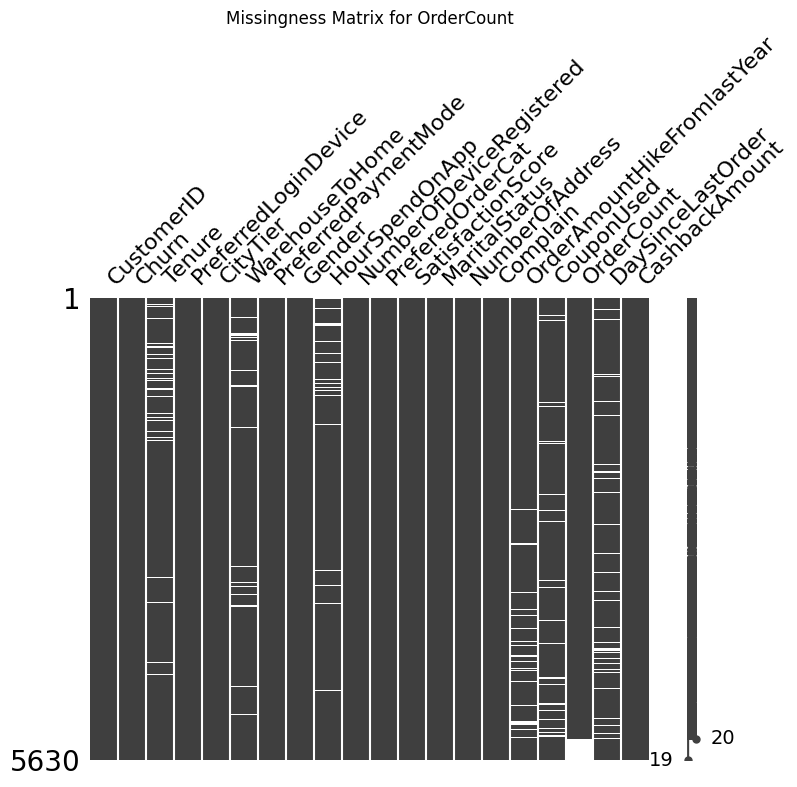

<Figure size 800x600 with 0 Axes>

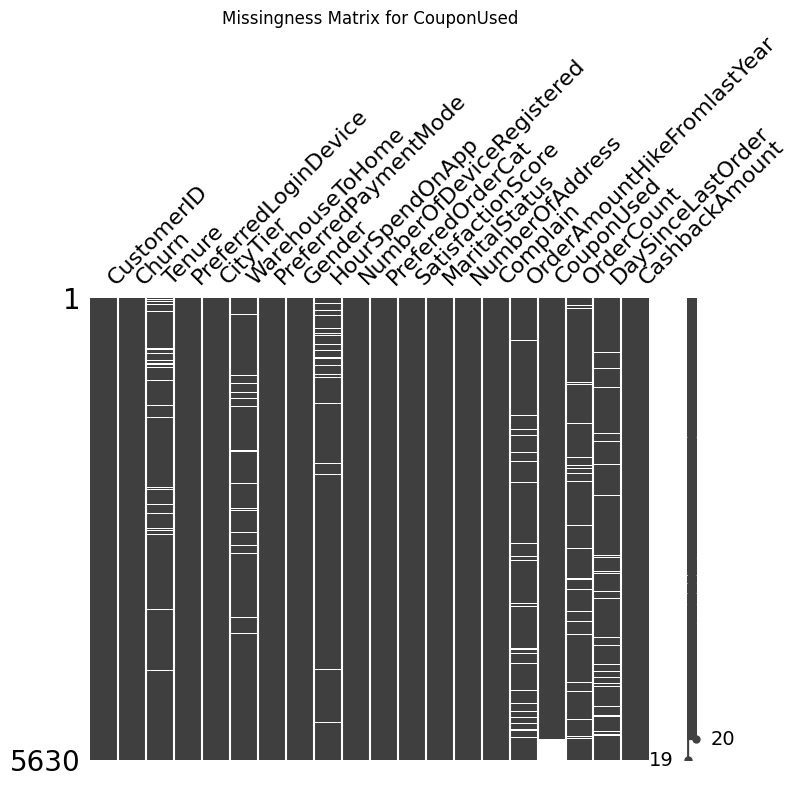

<Figure size 800x600 with 0 Axes>

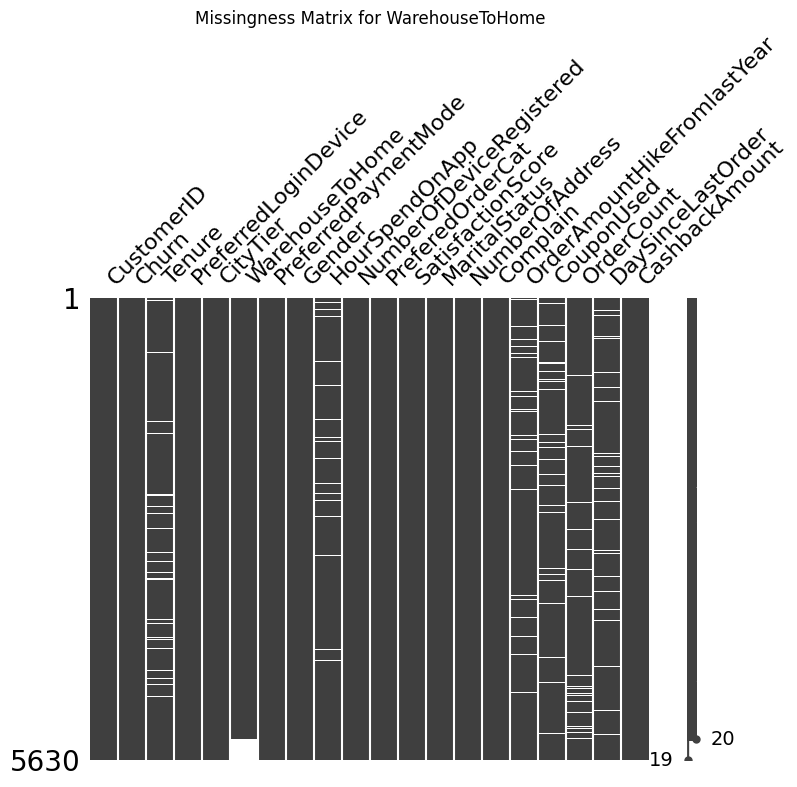

<Figure size 800x600 with 0 Axes>

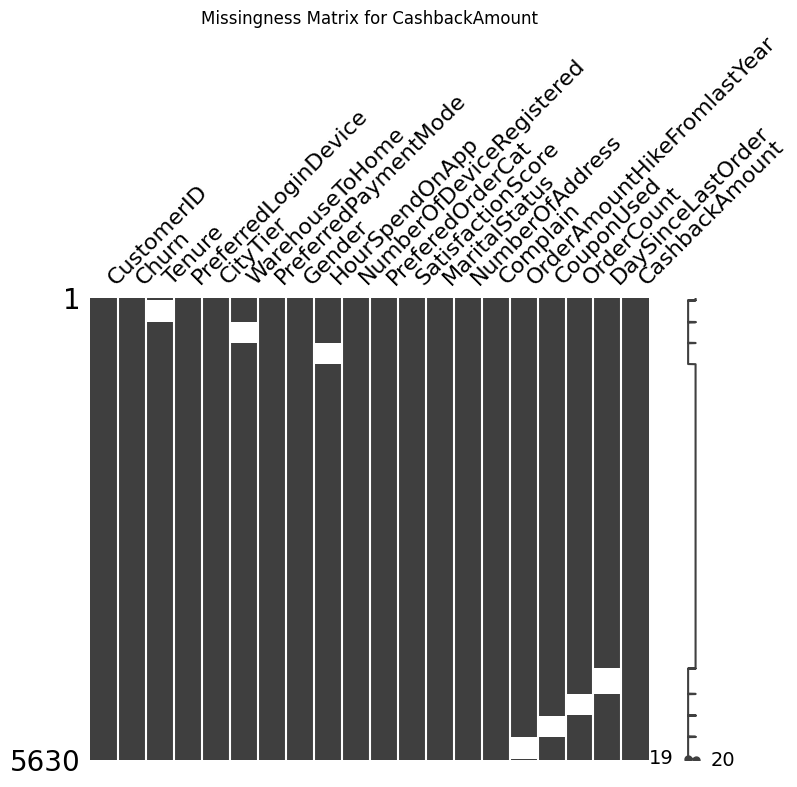

In [64]:
# List of column names
numerical_columns = ['Tenure', 'OrderCount', 'CouponUsed', 'WarehouseToHome', 'CashbackAmount']

# Plot the missingness matrix
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    msno.matrix(data.sort_values(by=column), figsize=(8, 6))
    plt.title(f'Missingness Matrix for {column}')
    plt.show()


**After sorting we can see the missing values follow a pattern with CashbackAmount.**

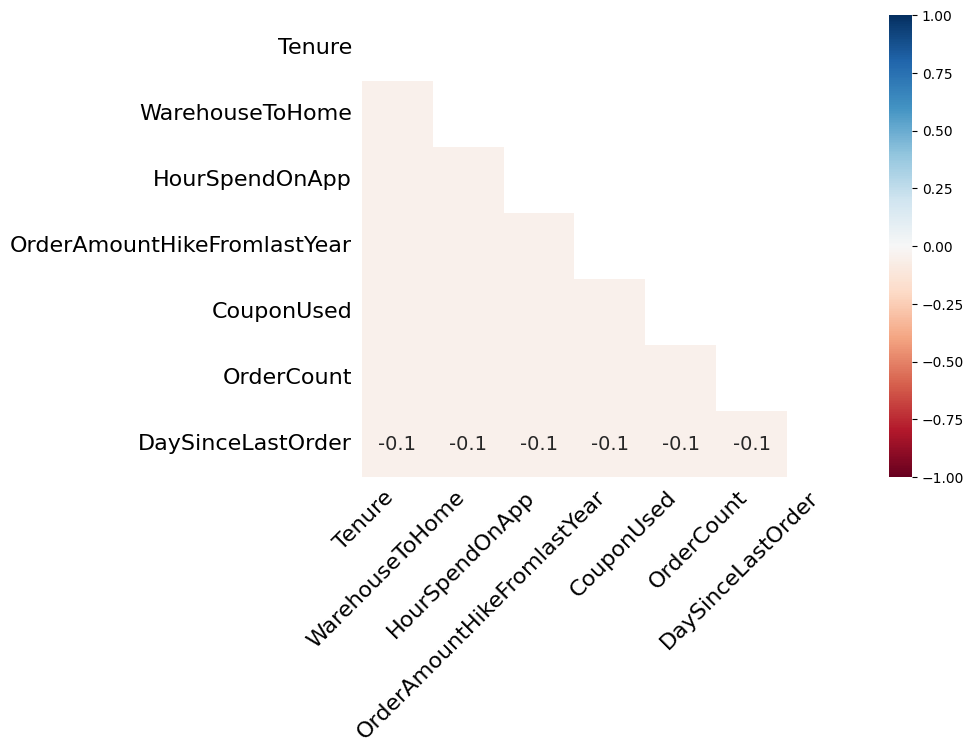

In [65]:
msno.heatmap(data, figsize=(8, 6))
plt.show()

## **Class Imbalance Using SMOTE**
* **Reason for using SMOTE:** SMOTE addresses class imbalance by generating synthetic samples for the minority class, preventing model bias and improving recognition of minority class patterns.



### **Categorical Encoding**

In [66]:
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Define features (X) and target variable (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

# Identify categorical columns
categorical_cols = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'MaritalStatus', 'Complain', 'PreferedOrderCat']

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', IterativeImputer(random_state=0), X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply the preprocessing pipeline to the entire dataset
X_preprocessed = preprocessor.fit_transform(X)

# Extract the encoded feature names
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

### **Applying SMOTE**

In [67]:
# Create a DataFrame with the encoded features and their specified column names
X_encoded = pd.DataFrame(X_preprocessed, columns=list(X.select_dtypes(include=['int64', 'float64']).columns) + list(encoded_feature_names))

# Split the data into training and testing sets
# Shuffle the data to ensure every test data point is randomed
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=0)

# Apply SMOTE for oversampling to training set only
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Continue with your model building using X_train_smote, y_train_smote and X_test
# For example, let's use a RandomForestClassifier with the same pipeline structure:

# Build Random Forest pipeline with SMOTE
rf_pipe_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('rfmodel', RandomForestClassifier())
])

# Train the model on the oversampled data
rf_pipe_smote.fit(X_train_smote, y_train_smote)

# Predictions on the test set
y_pred_smote = rf_pipe_smote.predict(X_test)

# Evaluate the model with a classification report
print("Classification Report with SMOTE:")
print(classification_report(y_test, y_pred_smote))

Classification Report with SMOTE:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       936
           1       0.93      0.84      0.88       190

    accuracy                           0.96      1126
   macro avg       0.95      0.91      0.93      1126
weighted avg       0.96      0.96      0.96      1126



**For churn(class 1) the precision is 0.92 but recall is 0.82, so there imbalance between them. So I am gonna test with different threshold values.**

In [68]:
from sklearn.metrics import classification_report

# Get predicted probabilities for class 1
y_probabilities = rf_pipe_smote.predict_proba(X_test)[:, 1]

# Define a range of threshold values
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Loop through each threshold value
for threshold in thresholds:
    # Apply the current threshold
    y_pred_adjusted = (y_probabilities >= threshold).astype(int)

    # Print classification report for the current threshold
    print(f"Classification Report with Threshold {threshold}:")
    print(classification_report(y_test, y_pred_adjusted))
    print("="*50)


Classification Report with Threshold 0.3:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       936
           1       0.75      0.95      0.84       190

    accuracy                           0.94      1126
   macro avg       0.87      0.94      0.90      1126
weighted avg       0.95      0.94      0.94      1126

Classification Report with Threshold 0.4:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       936
           1       0.87      0.92      0.90       190

    accuracy                           0.96      1126
   macro avg       0.93      0.95      0.94      1126
weighted avg       0.96      0.96      0.96      1126

Classification Report with Threshold 0.5:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       936
           1       0.92      0.85      0.88       190

    accuracy                           0.96      1126
  

**Since our priority is to identify churn, but at same time minimising false positive or negative prediction, so threshold value of 0.4 is being selected.**


Classification Report with Chosen Threshold:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       936
           1       0.87      0.92      0.90       190

    accuracy                           0.96      1126
   macro avg       0.93      0.95      0.94      1126
weighted avg       0.96      0.96      0.96      1126



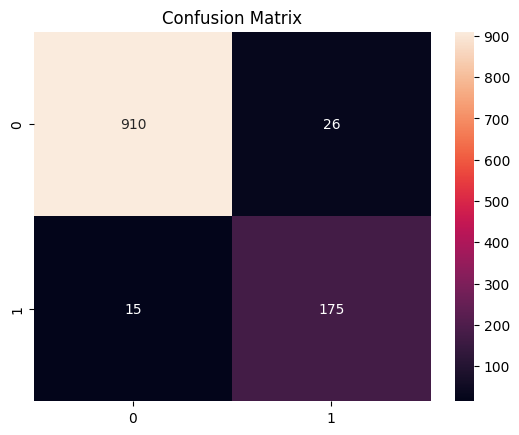

In [69]:
# Get predicted probabilities for class 1
y_probabilities = rf_pipe_smote.predict_proba(X_test)[:, 1]

# Apply the chosen threshold
chosen_threshold = 0.4
y_pred_final = (y_probabilities >= chosen_threshold).astype(int)

# Evaluate the final model
print("Classification Report with Chosen Threshold:")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_mat, annot=True, fmt="g")
plt.title("Confusion Matrix")
plt.show()


**Inerpreting the confusion matrix we get the following values -**
* Accuracy - 0.95
*Precision - 0.84
*Recall - 0.91
*F1-score - 0.87

## **K-Nearest Neighbors(KNN) Imputation**
* **Reason for using KNN for Imputation:** KNN imputation is chosen for its ability to estimate missing values based on the similarity between data points, making it suitable for datasets with spatial or temporal relationships.

**Using Logistic Regression Classifier**

In [70]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold

# Define StratifiedKFold for cross-validation
skfcv = StratifiedKFold(n_splits=5)

# K-nearest neighbors imputation
knn_imputer = KNNImputer(n_neighbors=5)
X_train_knn = knn_imputer.fit_transform(X_train)
X_test_knn = knn_imputer.transform(X_test)

# Create a KNN imputation pipeline with logistic regression
log_pipe_knn = Pipeline([('imputer', KNNImputer(n_neighbors=5)),
                          ('scaler', StandardScaler()),
                          ('logreg', LogisticRegression())])

# Cross-validate KNN imputation + Logistic Regression model
log_pipe_knn_cv_score = np.mean(cross_val_score(log_pipe_knn, X_train_knn, y_train, cv=skfcv, scoring='f1'))

# Fit and evaluate KNN imputation + Logistic Regression on the test set
log_pipe_knn.fit(X_train_knn, y_train)
log_pipe_knn_test_score = f1_score(y_test, log_pipe_knn.predict(X_test_knn))

# Print results
print(f"Cross-validation score for KNN Imputation + Logistic Regression: {log_pipe_knn_cv_score:.4f}")
print(f"Test score for KNN Imputation + Logistic Regression: {log_pipe_knn_test_score:.4f}")


Cross-validation score for KNN Imputation + Logistic Regression: 0.6308
Test score for KNN Imputation + Logistic Regression: 0.6607


**Using Random Forest Classifier**

In [71]:
from sklearn.ensemble import RandomForestClassifier

# K-nearest neighbors imputation
knn_imputer_rf = KNNImputer(n_neighbors=5)
X_train_knn_rf = knn_imputer_rf.fit_transform(X_train)
X_test_knn_rf = knn_imputer_rf.transform(X_test)

# Create a KNN imputation pipeline with Random Forest
rf_pipe_knn_imputation = Pipeline([('imputer', KNNImputer(n_neighbors=5)),
                                    ('scaler', StandardScaler()),
                                    ('rfmodel', RandomForestClassifier())])

# Cross-validate KNN imputation + Random Forest model
rf_pipe_knn_imputation_cv_score = np.mean(cross_val_score(rf_pipe_knn_imputation, X_train_knn_rf, y_train, cv=skfcv, scoring='f1'))

# Fit and evaluate KNN imputation + Random Forest on the test set
rf_pipe_knn_imputation.fit(X_train_knn_rf, y_train)
rf_pipe_knn_imputation_test_score = f1_score(y_test, rf_pipe_knn_imputation.predict(X_test_knn_rf))

# Print results
print(f"Cross-validation score for KNN Imputation + Random Forest: {rf_pipe_knn_imputation_cv_score:.4f}")
print(f"Test score for KNN Imputation + Random Forest: {rf_pipe_knn_imputation_test_score:.4f}")

Cross-validation score for KNN Imputation + Random Forest: 0.8263
Test score for KNN Imputation + Random Forest: 0.8579


**Using Gradient Boosting Classifier**

In [72]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a KNN imputation pipeline with Gradient Boosting
gb_pipe_knn_imputation = Pipeline([('imputer', KNNImputer(n_neighbors=5)),
                                    ('scaler', StandardScaler()),
                                    ('gbmodel', GradientBoostingClassifier())])

# Cross-validate KNN imputation + Gradient Boosting model
gb_pipe_knn_imputation_cv_score = np.mean(cross_val_score(gb_pipe_knn_imputation, X_train_knn_rf, y_train, cv=skfcv, scoring='f1'))

# Fit and evaluate KNN imputation + Gradient Boosting on the test set
gb_pipe_knn_imputation.fit(X_train_knn_rf, y_train)
gb_pipe_knn_imputation_test_score = f1_score(y_test, gb_pipe_knn_imputation.predict(X_test_knn_rf))

# Print results
print(f"Cross-validation score for KNN Imputation + Gradient Boosting: {gb_pipe_knn_imputation_cv_score:.4f}")
print(f"Test score for KNN Imputation + Gradient Boosting: {gb_pipe_knn_imputation_test_score:.4f}")

Cross-validation score for KNN Imputation + Gradient Boosting: 0.7111
Test score for KNN Imputation + Gradient Boosting: 0.7486


**After seeing the cross validation score and test score of KNN imputation with different classifier, Random Forest gives the best among the three.**
* Cross-validation score - 0.83
* Test score - 0.84

So I will proceed with using Random Forest KNN imputation.

In [73]:
from sklearn.ensemble import RandomForestClassifier

# Build Random Forest pipeline with KNN imputation
rf_pipe_knn = Pipeline([('imputer', KNNImputer(n_neighbors=5)),
                         ('scaler', StandardScaler()),
                         ('rfmodel', RandomForestClassifier(random_state=0))])

# Cross-validate Random Forest model with KNN imputation
rf_pipe_knn_cv_score = np.mean(cross_val_score(rf_pipe_knn, X_train_knn, y_train, cv=skfcv, scoring='f1'))

# Fit and evaluate Random Forest model with KNN imputation on the test set
rf_pipe_knn.fit(X_train_knn, y_train)
rf_pipe_knn_test_score = f1_score(y_test, rf_pipe_knn.predict(X_test_knn))

# Print results
print(f"Cross-validation score for Random Forest with KNN Imputation: {rf_pipe_knn_cv_score:.4f}")
print(f"Test score for Random Forest with KNN Imputation: {rf_pipe_knn_test_score:.4f}")


Cross-validation score for Random Forest with KNN Imputation: 0.8353
Test score for Random Forest with KNN Imputation: 0.8612


# **Model Development**

## **Ensemble Learning (Stacking)**
* **Reason for using Ensemble Learning with Stacking** - Ensemble Learning combines predictions for better performance. Stacking is chosen for its flexibility in combining diverse models, optimizing generalization.

### **Four Base Models**
* **XGBoost Classifier:** Powerful, fast, and effective.
* **Linear Discriminant Analysis (LDA):** Effective for linearly separable data.
* **Logistic Regression:** Simple yet effective for binary classification.
* **Random Forest:** Robust and capable of capturing complex patterns.

In [74]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

#Defining xgb_pipe
xgb_pipe = Pipeline([('imputer', IterativeImputer(random_state=0)),
                     ('scaler', StandardScaler()),
                     ('xgb', XGBClassifier(verbosity=0, use_label_encoder=False))])

# Definig lda_pipe
lda_pipe = Pipeline([('imputer', IterativeImputer(random_state=0)),
                     ('scaler', StandardScaler()),
                     ('lda', LinearDiscriminantAnalysis())])


# Build an ensemble using stacking with KNN imputation
estimators_knn = [('logreg_knn', log_pipe_knn), ('rf', rf_pipe_knn), ('lda', lda_pipe), ('xgb', xgb_pipe)]

stacking_model_knn = StackingClassifier(estimators=estimators_knn, final_estimator=RidgeClassifier())

# Cross-validate stacking model with KNN imputation
stacking_model_knn_cv_score = np.mean(cross_val_score(stacking_model_knn, X_train_knn, y_train, cv=skfcv, scoring='f1'))

# Fit and evaluate stacking model with KNN imputation on the test set
stacking_model_knn.fit(X_train_knn, y_train)
stacking_model_knn_test_score = f1_score(y_test, stacking_model_knn.predict(X_test_knn))

# Print results
print(f"Cross-validation score for Stacking with KNN Imputation: {stacking_model_knn_cv_score:.4f}")
print(f"Test score for Stacking with KNN Imputation: {stacking_model_knn_test_score:.4f}")

Cross-validation score for Stacking with KNN Imputation: 0.8792
Test score for Stacking with KNN Imputation: 0.9167


In [75]:
# Predictions on the test set
y_pred_stacking_knn = stacking_model_knn.predict(X_test_knn)

# Calculate accuracy
accuracy_stacking_knn = accuracy_score(y_test, y_pred_stacking_knn)

# Print accuracy
print(f"Accuracy for Stacking with KNN Imputation: {accuracy_stacking_knn:.4f}")

# Calculate confusion matrix
conf_matrix_stacking_knn = confusion_matrix(y_test, y_pred_stacking_knn)

# Print confusion matrix
print("Confusion Matrix for Stacking with KNN Imputation:")
print(conf_matrix_stacking_knn)

Accuracy for Stacking with KNN Imputation: 0.9716
Confusion Matrix for Stacking with KNN Imputation:
[[918  18]
 [ 14 176]]


**Interpreting the above results, we get -**
* Precison - 0.90
* Recall - 0.92
* F1-score - 0.91
* Accuracy - 0.97

# **Feature Analysis**
* I am using **Permutation Importance** so that I can know which features contribute in influencing churn

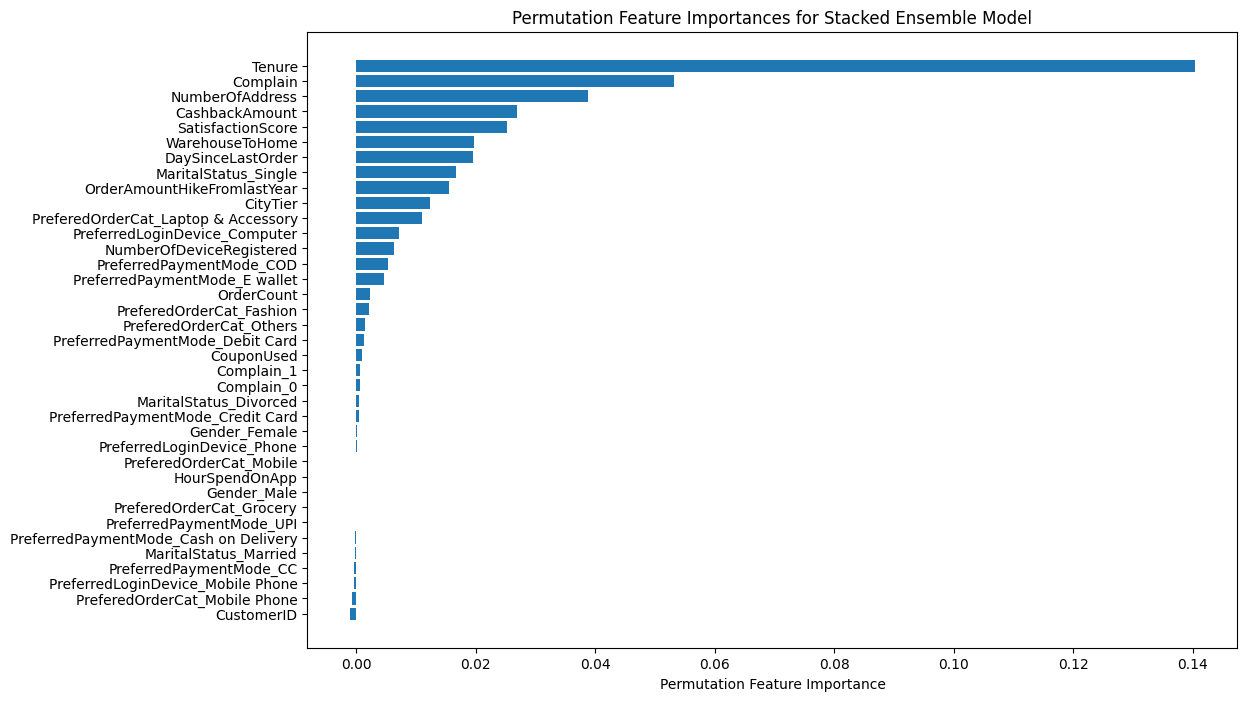

In [76]:
from sklearn.inspection import permutation_importance

# Name of the ensemble model
ensemble_model = stacking_model_knn

# Perform permutation feature importance
result = permutation_importance(ensemble_model, X_test_knn, y_test, n_repeats=30, random_state=0)

# Get feature importances and indices
feature_importances = result.importances_mean
feature_indices = np.argsort(feature_importances)

# Plot the permutation feature importances
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_indices)), feature_importances[feature_indices])
plt.yticks(range(len(feature_indices)), X_test.columns[feature_indices])  # Use X_test instead of X_test_knn
plt.xlabel('Permutation Feature Importance')
plt.title('Permutation Feature Importances for Stacked Ensemble Model')
plt.show()

### **Predictiing churn using dummy dataset**

In [77]:
# Creating a dummy dataset with 10 rows and 37 features
np.random.seed(42)

dummy_data = {
    f'Feature{i}': np.random.randint(1, 100, size=10) for i in range(1, 38)
}

dummy_df = pd.DataFrame(dummy_data)

# Use the stacking model to predict churn
predictions = stacking_model_knn.predict(dummy_df)

# 'predictions' now contains the predicted churn labels (0 or 1) for each row in the dummy dataset
print(predictions)


[0 0 1 0 0 1 0 0 0 1]


# **Summary**




### **Factors Influencing Churn:**

1. **Tenure:** Customers with shorter tenure are more likely to churn.
2. **Complaints:** Higher complaint rates are associated with increased churn.
3. **Cashback Amount:** Customers receiving higher cashback amounts are less likely to churn.
4. **Warehouse to Home:** Longer delivery times (Warehouse to Home) may contribute to churn.
5. **Days Since Last Order:** Longer durations since the last order correlate with higher churn.
6. **Marital Status (Single):** Single customers may have a higher likelihood of churning.

### **Actions To Prevent Churn:**

* **Personalized Retention Programs:**

 * Develop personalized retention programs based on customer tenure.
 * Offer exclusive deals and promotions to customers with shorter tenure.

* **Proactive Customer Support:**

 * Proactively address customer complaints and concerns.
 * Implement feedback mechanisms to continuously improve service quality.

* **Enhanced Loyalty Programs:**

 * Strengthen cashback programs to reward loyal customers.
 * Introduce tiered loyalty benefits to encourage sustained engagement.

* **Logistics Optimization:**

 * Optimize logistics and reduce delivery times.
 * Communicate transparently with customers about delivery timelines.

* **Re-Engagement Campaigns:**

 * Launch targeted campaigns to re-engage customers who haven't made recent purchases.
 * Offer special incentives to encourage repeat orders.

* **Segmented Marketing for Marital Status:**

 * Tailor marketing messages and offers based on marital status.
 * Understand and cater to the unique preferences of single customers.